https://cedric.cnam.fr/~soutif/QKP/QKP.html

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import scipy
# import cvxpy as cp

In [4]:
from utils import replace_invalid_particles, project_vectors

In [5]:
dtype = torch.float32

In [6]:
with open('legacy/jeu_100_25_2.txt', 'r') as f:
    lines = f.read().split('\n')

In [7]:
dim = int(lines[1])
diag = np.array([int(x) for x in lines[2].split()])

off_diag = []

for i in range(3, dim + 3 - 1):
    off_diag.append(np.array([int(x) for x in lines[i].split()]))
    
constraint_type = int(lines[dim + 3])
# 0 if the constraint is of type <= (i.e. always since we are considering (QKP) instances)
# and 1 if the constraint is an eglity constraint
print(constraint_type) 

capacity = int(lines[dim + 3 + 1])
capacity

weights = np.array([int(x) for x in lines[dim + 3 + 2].split()])

A = np.zeros((dim, dim))
for i in range(dim):
    A[i, i] = diag[i] / 2
    if i < dim - 1:
        A[i, i+1:] = off_diag[i] / 2
        
A += A.T

0


In [8]:
A_torch = torch.tensor(A, dtype=dtype)
weights_torch = torch.tensor(weights, dtype=dtype)

In [9]:
potential = lambda x: -torch.einsum('ni,ij,nj->n', x, A_torch, x)
isvalid = lambda x: (x >= 0).all(axis=-1) * (x <= 1).all(axis=-1) * (x @ weights_torch <= capacity)

def cost(x, w):
    vals = potential(x) - w * (torch.log(x) + torch.log(1 - x)).sum(axis=-1) \
                - w * torch.log(capacity - x @ weights_torch)
    return vals

In [166]:
num_particles = 100
particles = torch.tensor(np.zeros((num_particles, dim)) + 0.001, dtype=dtype, requires_grad=True)

In [245]:
w = 10000
num_iters = 1000
lr = 0.001
history = torch.zeros((num_iters, num_particles, dim), dtype=dtype)

for i in range(num_iters):
    val = cost(particles, w)
    val.sum().backward()
    
    with torch.no_grad():
        scaled_grad = project_vectors(particles.grad, 2)
        # scaled_grad = torch.clip(particles.grad, min=-1, max=1)
        particles += -lr * scaled_grad + 0.01 * np.sqrt(2 * lr) * torch.randn_like(particles)
        torch.clip(particles, min=1e-6, max=1-1e-6, out=particles)
        replace_invalid_particles(particles, isvalid(particles))
        
        history[i] = particles.detach().clone()
    particles.grad.zero_()

history = history.transpose(1, 0)

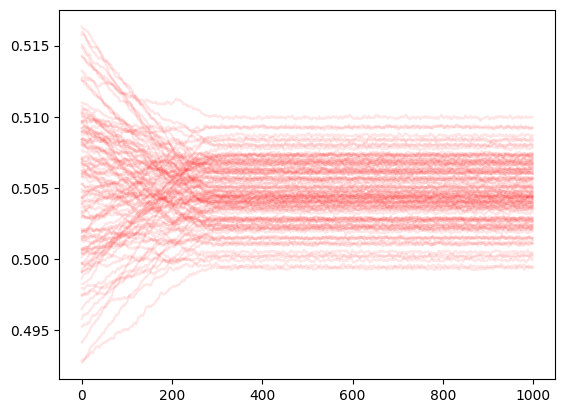

In [246]:
plt.plot(history.mean(axis=0), color='red', alpha=0.1);

In [247]:
history.shape

torch.Size([100, 1000, 100])

In [248]:
rounded_particles = torch.round(particles.detach().clone())

In [249]:
isvalid(rounded_particles)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [250]:
potential(rounded_particles[isvalid(rounded_particles)]).min()

InvalidOperation: [<class 'decimal.DivisionUndefined'>]